In [1]:
function [X_norm, mu, sigma] = featureNormalize(X)
    mu = mean(X);
    sigma = std(X);
    sigma(sigma==0)=1;   
    X_norm = [(X - mu) ./ sigma];
end

In [2]:
function [X_norm, mu, sigma] = featureNormalize2(X)
    mu = mean(X);
    sigma = std(X);
    sigma(sigma==0)=1;   
    ix_norm = sigma > 10;
    X_norm = X;

    if sum(ix_norm) > 0
        X_norm(:,ix_norm) = [(X(:,ix_norm) - mu(ix_norm)) ./ sigma(ix_norm)];
    end
end

In [3]:
function opts = init_opts_swmtl(opts)
    if ~isfield(opts, 'rho')
        opts.rho = 10;
    end 
    
    if ~isfield(opts, 'lambda')
        opts.lambda = 5; 
    end
    
    if ~isfield(opts, 'c')
        opts.c = 1; 
    end
    
    if ~isfield(opts, 'lr')
        opts.lr = 10^-3;
    end
    
    if ~isfield(opts, 'optimizer')
        opts.optimizer = 3;
    end
    
    if ~isfield(opts, 'max_iters')
        opts.max_iters = 1000;
    end
    
    if ~isfield(opts, 'tol')
        opts.tol = 10^-4;
    end
    
    if ~isfield(opts, 'scaling')
        opts.scaling = 1; % 1 is Z normal scaling, 2 is min max scaling
    end
        
    if ~isfield(opts, 'tflag')
        opts.tflag = 1; % percentage change
    end

end

In [4]:
function ut = updateU(X, Y, W, U, L, t, lambda, rho, c)
    T = length(X);
    xt = X{t};
    yt = Y{t};
    wt = W(:,t);
    ut = U(:,t);
    lt = L(:,t);
    d = size(xt, 2);   
    
    if rho != 0
    if t == 1 
        utn = U(:,t+1);
        slackGrad = ut .* utn;
        ut(slackGrad >= 0) = wt(slackGrad >= 0) + 1/(rho) * lt(slackGrad >= 0);
        ut(slackGrad < 0) = wt(slackGrad < 0) + 1/(rho) * ( c*utn(slackGrad < 0) + lt(slackGrad < 0) );
    elseif t == T
        utp = U(:,t-1);  
        slackGrad = ut .* utp;
        ut(slackGrad >= 0) = wt(slackGrad >= 0) + 1/(rho) * lt(slackGrad >= 0);
        ut(slackGrad < 0) = wt(slackGrad < 0) + 1/(rho) * (c*utp(slackGrad < 0) + lt(slackGrad < 0) );    
    else
        utp = U(:,t-1);
        utn = U(:,t+1);        
        slackGrad1 = ut .* utn;
        slackGrad2 = ut .* utp;
        
        ix = slackGrad1 >= 0 & slackGrad2 >= 0;
        ut(ix) = wt(ix) + 1/(rho) * lt(ix) ;
        
        ix = slackGrad1 >= 0 & slackGrad2 < 0;
        ut(ix) = wt(ix) + 1/(rho) * ( c*utp(ix) + lt(ix) );   
        
        ix = slackGrad1 < 0  & slackGrad2 >= 0;
        ut(ix) = wt(ix) + 1/(rho) * ( c*utn(ix) + lt(ix) );
        
        ix = slackGrad1 < 0  & slackGrad2 < 0;
        ut(ix) = wt(ix) + 1/(rho) * ( c*utp(ix) +  c*utn(ix) + lt(ix) );
    end
    end

end

In [5]:
function [h] = sigmoid(z)
    h = 1./(1+ e.^-z);
end

In [6]:
function [J,grad] = computeGradients(X, Y, W, U, L, t, lambda, rho, c)
    T = length(X);
    xt = X{t};
    yt = Y{t};
    wt = W(:,t);
    ut = U(:,t); 
    lt = L(:,t);
    [m, d] = size(xt);
        
    yt_hat = xt*wt;
    h = sigmoid(yt_hat);
    smooth_cost = 1/(2*m) * (-yt' * log(max(h,eps)) - (1-yt)' * log(1-min(h,1-eps)));
    reg_cost = lambda/(2*m) * sum(wt.^2);

    if t == 1
        utn = U(:,t+1);
        slack = c * sum(max(0, - ut.*utn));
    elseif t < T
        utp = U(:,t-1);
        utn = U(:,t+1);
        slack = c * (sum(max(0, - ut.*utp)) + sum(max(0, - ut.*utn)));
    else
        utp = U(:,t-1);
        slack = c * sum(max(0, - ut.*utp));
    end
    
    J = smooth_cost + reg_cost + slack;    
    
    if rho!= 0 
        lagrange_grad = rho*(wt-ut+ lt/rho);
    else
        lagrange_grad = 0;
    end
    
    smooth_grad = (1/m)*xt' * (h - yt) + (1/m)*lambda*wt;
    lagrange_grad = rho * (wt-ut) + lt;
    grad = smooth_grad + lagrange_grad;
    
end

In [7]:
function [wt, jt] = minimizeJ(X, Y, W, U, L, t, i,opts)
    T = length(X);
    xt = X{t};
    yt = Y{t};
    wt = W(:,t);
    ut = U(:,t); 
    lt = L(:,t);
    [m, d] = size(xt);

    % momentum
    mlr_V = ones(d,1);     
    mlr_mu = 0.9;
    mlr_alpha = opts.lr;
    % accelerated gradient
    nag_V = ones(d,1);
    nag_mu = 0.9;
    nag_alpha = opts.lr;
    % adagrad
    % rmsprop
    rmsprop_gamma = 0.01;
    rmsprop_r=wt;


    for iter = 1:opts.max_iters
%        fprintf('\r iter: %d task: %d training iter: %d ',i, t, iter);
    
        if opts.optimizer == 3
            nag_W = W + nag_mu * nag_V;
            [cost, grad_W] = computeGradients(X, Y, nag_W, U, L, t,  opts.lambda, opts.rho, opts.c);
        else
            [cost, grad_W] = computeGradients(X, Y, W, U, L, t,  opts.lambda, opts.rho, opts.c);
        end
        
        if opts.optimizer == 1 % GD
            W(:, t) = W(:, t) - opts.lr * grad_W;
        elseif opts.optimizer == 2 % momentum GD
            mlr_V(:, t) = mlr_mu * mlr_V - mlr_alpha * grad_W;
            W(:, t) = W(:, t) + mlr_V(:, t);
        elseif opts.optimizer == 3 % NAG
            nag_V(:, t) = nag_mu * nag_V - nag_alpha * grad_W;
            W(:, t) = W(:, t) + nag_V(:, t);
        elseif opts.optimizer == 4
            adagrad_hist(iter,:) = grad_W;
            adagrad_W = grad_W ./ sqrt(sum(adagrad_hist.^2))';
            W(:, t) = W(:, t) - opts.lr * adagrad_W;
        elseif opts.optimizer == 5 % rmsprop
            %size(rmsprop_r), size(grad_W)
            rmsprop_r = rmsprop_gamma*rmsprop_r + (1-rmsprop_gamma)*grad_W.^2;
            W(:, t) = W(:, t) - opts.lr * grad_W./ sqrt(rmsprop_r);
        end   
            
        J_history(iter) = cost;
        
        if iter >1 
            prev_hist = J_history(iter-1);
            curr_hist = J_history(iter);

            if opts.tflag == 1
                delta_hist(iter) = abs(prev_hist - curr_hist) ./ prev_hist;
                if sum(delta_hist(end) > opts.tol) == 0
                    break
                end                                
            elseif opts.tflag == 2
                delta_hist(iter) = abs(prev_hist - curr_hist);                
                if sum(delta_hist(end) > opts.tol) == 0
                    break
                end
            else # 0 : not stop criteria
                delta_hist(iter) = abs(prev_hist - curr_hist);
            end
        end
    
    end
    
    wt = W(:,t);
    jt = J_history;
    
end

In [35]:
function [W, J_hist, J_hist_all, primal_residual_val, dual_residual_val] = Least_SWMTL3(X, Y, opts)

    % hyperparameters
    opts = init_opts_swmtl(opts) ;  

    % data variables
    T = length(X);
    d = size(X{1},2);   
    
    if opts.scaling
        %d = d + 1;
        d = d;
    end
    
    % output variables
    if isfield(opts, 'W0')
        W = opts.W0;
    else
        W = rand(d,T);     
    end

    % internal variables
    U = W;
    L = W;

    
    % data normalization
    if opts.scaling
        disp('scaling data')
        for t=1:T 
            if opts.scaling == 1
                [X{t}, mu_X(:,t), sigma_X(:,t)] = featureNormalize(X{t});
                %[Y{t}, mu_Y(:,t), sigma_Y(:,t)] = featureNormalize(Y{t});
            elseif opts.scaling == 2
                [X{t}, mu_X(:,t), sigma_X(:,t)] = featureNormalize2(X{t});
                %[Y{t}, mu_Y(:,t), sigma_Y(:,t)] = featureNormalize2(Y{t});
            end
        end
    end
    
    %init history
    disp('initializing hist')
    for t=1:T
        J_hist{t} =[];
    end
        
    
    i = 1; % the iteration counter
    while i <= opts.max_iters 

        U_previous = U;
        
        J_hist_all(i) = 0;
        
        for t = 1:T        
            [wt, jt]=minimizeJ(X, Y, W, U, L, t,i, opts);            
            W(:, t) = wt;
            J_hist{t} = vertcat([J_hist{t}, jt]);            
            last_cost= J_hist{t}(end);
            J_hist_all(i) =J_hist_all(i) + last_cost;
            
            fprintf('\r iter: %d task: %d cost: %d' ,i, t, last_cost);
        end
        
        for t = 1:T
            U(:,t) = updateU(X, Y, W, U, L, t, opts.lambda, opts.rho, opts.c);                                
        end


        primal_residual = W-U ;
        dual_residual = -opts.rho * (U - U_previous);
        primal_residual_val(i) = sqrt(sum(sum(primal_residual.^2)));
        dual_residual_val(i) = sqrt(sum(sum(dual_residual.^2)));
            
        % stop criteria
        if i >1 
            prev_hist = J_hist_all(end-1);
            curr_hist = J_hist_all(end);

            if opts.tflag == 1
                delta_hist = abs(prev_hist - curr_hist) ./ prev_hist;
                if (delta_hist > opts.tol) == 0
                    break
                end                                
            elseif opts.tflag == 2
                delta_hist = abs(prev_hist - curr_hist);                
                if (delta_hist > opts.tol) == 0
                    break
                end
            else
                delta_hist = abs(prev_hist - curr_hist);
            end
        end
        
        
        L = L + opts.rho*(W-U);
        i = i + 1;

    end
        
    if opts.scaling == 1
        W=[W./sigma_X];             
    elseif opts.scaling == 2
        ix_sigma = sigma_X > 10;
        W(ix_sigma)=W(ix_sigma)./sigma_X(ix_sigma);              
    end

end

In [9]:
!ls ../data

04cars.mat				syntheticWMTLC8t5m100d2p0s0.mat
20news.mat				syntheticWMTLR1.mat
WebKB.mat				syntheticWMTLR2t20m100d20p0s0.mat
china_air				syntheticWMTLR2t5m100d1p0s0.mat
civil					syntheticWMTLR2t5m100d1p0s1.mat
civilBrazil.mat				syntheticWMTLR2t5m100d1p1s0.mat
civilColombia.mat			syntheticWMTLR3t20m100d20p0s0.mat
civilMexico.mat				syntheticWMTLR3t5m100d1p0s0.mat
civilParaguay.mat			syntheticWMTLR3t5m100d1p0s1.mat
civilVenezuela.mat			syntheticWMTLR3t5m100d1p1s0.mat
computerBuyers				syntheticWMTLR3t5m200d1p1s0.mat
computerBuyers.mat			syntheticWMTLR4t20m100d25p0s0.mat
crisisnlp.mat				syntheticWMTLR4t5m100d1p0s0.mat
facebook.mat				syntheticWMTLR5t20m100d25p0s0.mat
flu					syntheticWMTLR5t5m100d1p0s0.mat
fluUS2012.mat				syntheticWMTLR6t20m100d25p1s0.mat
isolet					syntheticWMTLR6t5m100d1p0s0.mat
isolet.mat				syntheticWMTLR7t20m100d25p1s0.mat
multilingual				syntheticWMTLR7t20m500d25p0s0.mat
school.mat				syntheticWMTLR8t100m100d1000p0s0.mat
sentiMD					syntheticWMTLR8t100m100d10

# 1D dataset

In [10]:
clear;
load('../data/unrestVenezuela.mat');
T = length(X)
whos

T =  68
Variables in the current scope:

   Attr Name               Size                     Bytes  Class
   ==== ====               ====                     =====  ===== 
        T                  1x1                          8  double
        X                  1x68                  29497120  cell
        Y                  1x68                    198560  cell
        dataset_type       1x11                        11  char
        num_features       1x1                          8  double
        num_instances      1x1                          8  double
        num_tasks          1x1                          8  double

Total is 151 elements using 29695723 bytes



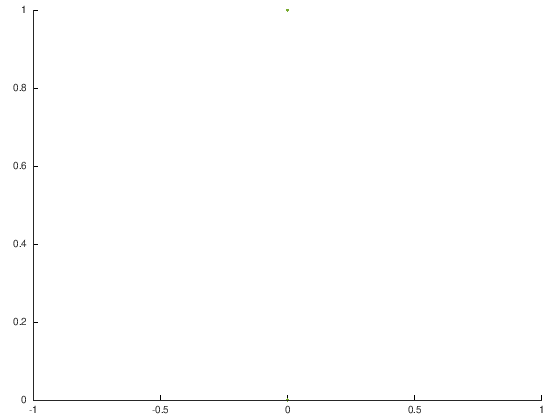

In [11]:

hold on;
    
for t=1:T
    plot(X{t}(:,1), Y{t} , '.' )
    %text(mean(X{t}(:,1)), mean(Y{t}), num2str(t), 'fontsize', 14)
end



## normalize data

error: featureNormalize: operator -: nonconformant arguments (op1 is 365x1806, op2 is 1x1806)
error: called from
    featureNormalize at line 5 column 12


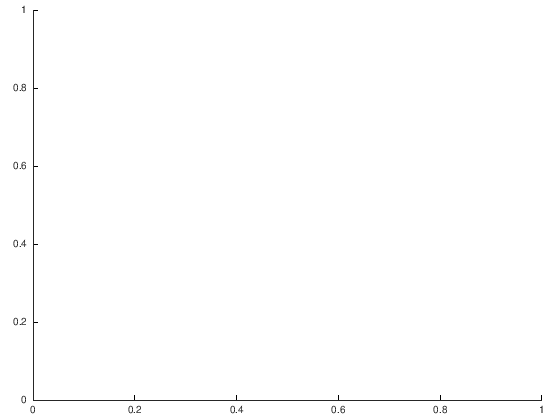

In [12]:
hold on;

for t=1:T
    % normalize data
    [X_norm{t}, muv, sigmav] = featureNormalize(X{t});
    mu{t} = muv';
    sigma{t}= sigmav';
    [Y_norm{t}, y_muv, y_sigmav] = featureNormalize(Y{t});
    y_mu{t}=y_muv';
    y_sigma{t}=y_sigmav';
    plot(X_norm{t}(:,1), Y_norm{t} , '.' )
    #text(mean(X_norm{t}(:,1)), mean(y_norm{t}), num2str(t), 'fontsize', 14);
end

In [64]:
opts = struct('rho', 0, 'lambda', 0.01, 'c', 0, ...
    'lr', 0.1, 'tol', 10^-2, 'scaling', 0, ...
    'optimizer', 4, 'tflag', 1, 'max_iters', 100)
    
[w , obj_history, J_hist_all] = Least_SWMTL3(X, Y, opts);

opts =

  scalar structure containing the fields:

    rho = 0
    lambda =  0.010000
    c = 0
    lr =  0.10000
    tol =  0.010000
    scaling = 0
    optimizer =  4
    tflag =  1
    max_iters =  100

initializing hist
 iter: 8 task: 68 cost: 0.0622973

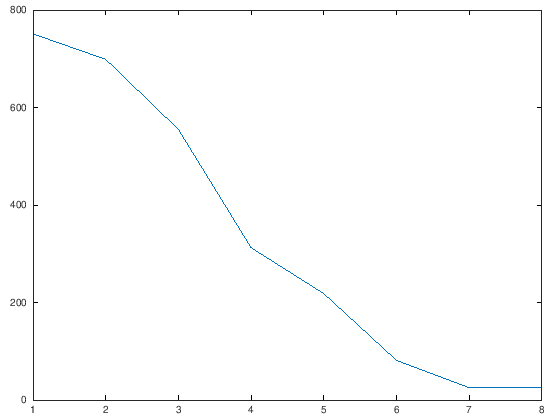

In [65]:
plot(J_hist_all)

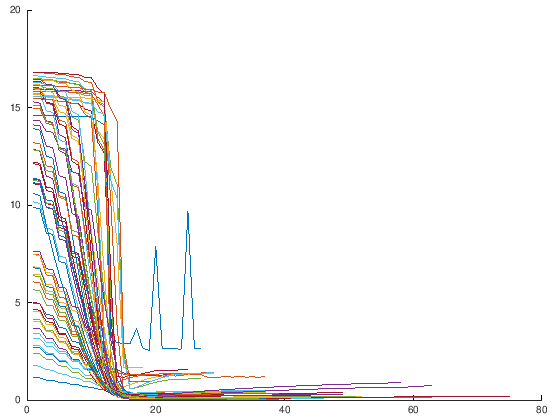

In [66]:
hold on;

for t=1:T
    %semilogy(pr(3:end), 'DisplayName', ['L' num2str(t)])
    plot(obj_history{t}, 'DisplayName', ['L' num2str(t)])
end

%legend;
% figure(1, 'position',[0,0,1000,500]);

% subplot(1,2,1)
% plot(pr)
% subplot(1,2,2)
% plot(dr)


In [67]:

[w(1:5,1:3), cell2mat(W)(1:5,1:3)]


error: 'W' undefined near line 1 column 23


In [68]:
% figure(1, 'position',[0,0,500,2500]);

% for t=1:5
%     subplot(T,1, t)
%     scatter(X{t}(:,1), Y{t}, 'b' , 's')
%     hold on
%     m = size(X{t},1);
%     %Y_hat{t} = X{t} * w(:, t);
%     Y_hat{t} = X{t} * w_hat(:, t);
%     %Y_hat{t} = [ones(m,1) X_norm{t}] * w(:, t);
%     scatter(X{t}(:,1), Y_hat{t}, 'r')
% end

In [75]:
addpath('../src/utils/');
addpath('../src/models/');

In [77]:
train_size=0.8
random_state='reset'
[X_train, Y_train, X_test, Y_test] = datasplit(X, Y, train_size, random_state);

train_size =  0.80000
random_state = reset


In [78]:
X_train=X;
Y_train=Y;

In [102]:
% scaling =  1
%     tol =  0.0010000
%     lr =  0.010000
%     optimizer =  4
%     max_iters =  100
%     lambda =  0.00056234
%     rho =  0.10000
%     c =  0.000010000
    
opts = struct('rho', 1, 'lambda', 0.01, 'c', 0.00001, ...
    'lr', 0.01, 'tol', 0.001, 'scaling', 0, ...
    'optimizer',4, 'tflag',1, 'max_iters', 100)
    
[w , obj_history] = Least_SWMTL3(X, Y, opts);



opts =

  scalar structure containing the fields:

    rho =  1
    lambda =  0.010000
    c =  0.000010000
    lr =  0.010000
    tol =  0.0010000
    scaling = 0
    optimizer =  4
    tflag =  1
    max_iters =  100

initializing hist
 iter: 100 task: 68 cost: 0.0483723

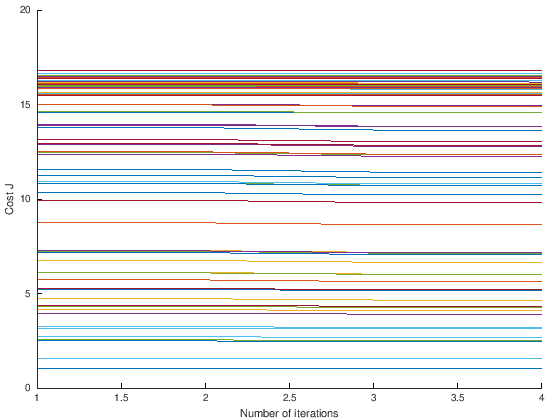

In [101]:

hold on;

for t=1:T
    %semilogy(pr(3:end), 'DisplayName', ['L' num2str(t)])
    plot(obj_history{t}, 'DisplayName', ['L' num2str(t)])
    %break
end

xlabel('Number of iterations');
ylabel('Cost J');

In [85]:
for i = 1: t
    Y_hat{i} = round(sigmoid(X{i} * w(:,i)));    
end

In [87]:
test_data = load ('../data/unrestVenezuela2014.mat');
X_test = test_data.X;
Y_test = test_data.Y;

In [88]:
[AUC, ACC, MAP]=mtclf_test_sigmoid(X_test,w,Y_test, opts)

t =  68
AUC =  0.63259
ACC =  0.88139
MAP =  0.027228
